In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Z and mag filters :

In [3]:
# mag filters :

object_mag_filters = ['mag_i_cModel < 26.5', 'mag_i_cModel > 18',
    (np.isfinite, 'mag_i_cModel'), (np.isfinite, 'mag_r_cModel'), (np.isfinite, 'mag_z_cModel')]

truth_mag_filters = ['mag_i<28','mag_i>18',(np.isfinite, 'mag_i'), (np.isfinite, 'mag_r'), (np.isfinite, 'mag_z')]

'''# z filters (grande):

object_z_filters = ['photoz_mean < 1.5', (np.isfinite, 'photoz_mean')]

truth_z_filters = ['redshift < 1.5', (np.isfinite, 'redshift')] '''

"# z filters (grande):\n\nobject_z_filters = ['photoz_mean < 1.5', (np.isfinite, 'photoz_mean')]\n\ntruth_z_filters = ['redshift < 1.5', (np.isfinite, 'redshift')] "

### CosmoDC2 and DC2Objects (truth and object) :

In [4]:
import GCRCatalogs
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [5]:
cosmodc2.get_quantity_info('is_central')

In [6]:
#data object catalog :

object_quantities = ['ra', 'dec', 'mag_i_cModel', 'photoz_mean']

object_data = (dc2.get_quantities(object_quantities,
                                 filters=['extendedness>0', 'clean']+object_mag_filters,
                                 native_filters=['tract==4026']))

print(type(object_data))

<class 'dict'>


In [7]:
# data truth catalog :

eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [8]:
truth_quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift', 'is_central', 'halo_mass', 'halo_id']

truth_data = (cosmodc2.get_quantities(truth_quantities, 
                                      filters=truth_mag_filters+pos_filters, 
                                      native_filters=healpix_filter))

In [9]:
list(truth_data)

['is_central',
 'halo_id',
 'halo_mass',
 'dec',
 'ra',
 'galaxy_id',
 'mag_i',
 'redshift']

In [10]:
truth_data['halo_mass']

array([5.07006249e+12, 5.07006249e+12, 3.79915201e+10, ...,
       3.90086208e+10, 5.72330995e+10, 3.13850793e+10])

In [11]:
print("nombre de galaxies =", len(truth_data['ra']))
print("nombre de galaxies centrales =", len(np.where(truth_data['is_central']==True)[0]))
print("pourcentage de galaxies centrales =", (len(np.where(truth_data['is_central']==True)[0])/len(truth_data['ra']))*100, '%')
print("nombre d'objets =", len(object_data['ra']))

nombre de galaxies = 2920943
nombre de galaxies centrales = 2669420
pourcentage de galaxies centrales = 91.38897951791596 %
nombre d'objets = 676713


(array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]),
 [Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$')])

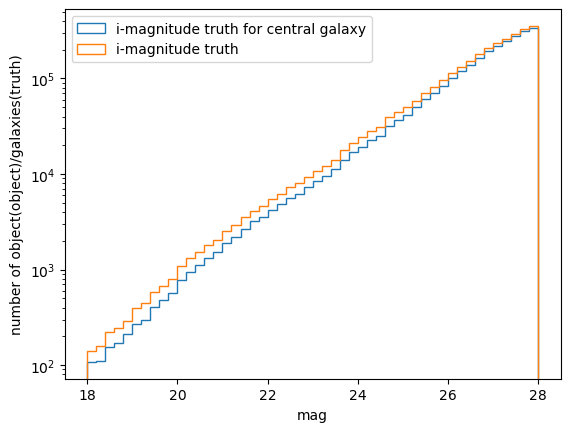

In [12]:
plt.figure()
truth_hist_central=plt.hist(truth_data['mag_i'][np.where(truth_data['is_central']==True)[0]], bins=50, 
                            histtype='step', label='i-magnitude truth for central galaxy', log=True)
truth_hist=plt.hist(truth_data['mag_i'], bins=50, histtype='step', label='i-magnitude truth', log=True)
plt.legend()
plt.xlabel('mag')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()

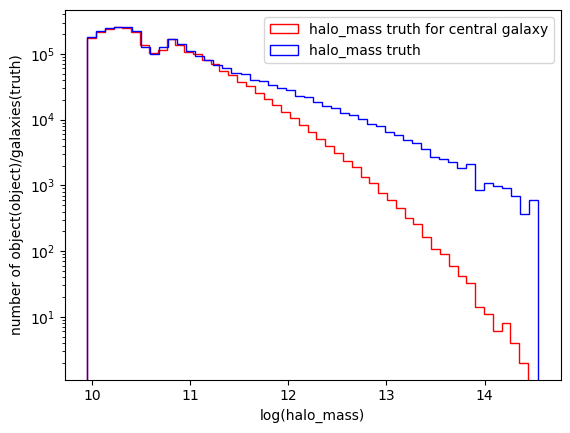

In [13]:
plt.figure()
truth_hist_central=plt.hist(np.log10(truth_data['halo_mass'])[np.where(truth_data['is_central']==True)[0]], bins=50, 
                            histtype='step', label='halo_mass truth for central galaxy', log=True, color='red')
truth_hist=plt.hist(np.log10(truth_data['halo_mass']), bins=50, histtype='step', label='halo_mass truth', log=True, color='blue')
plt.legend()
plt.xlabel('log(halo_mass)')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()
plt.savefig('Histo halo_mass')
plt.show()

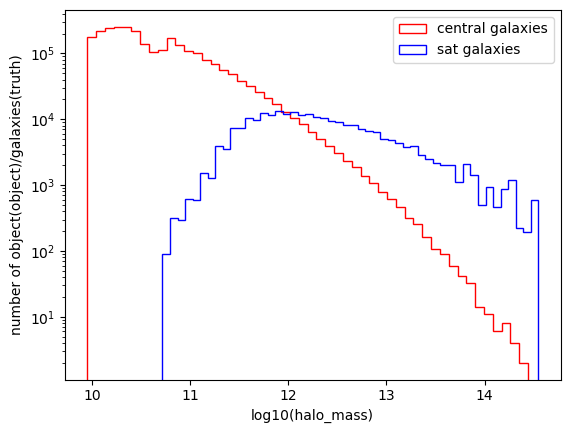

In [14]:
plt.figure()
truth_hist_central=plt.hist(np.log10(truth_data['halo_mass'])[np.where(truth_data['is_central']==True)[0]], bins=50, 
                            histtype='step', label='central galaxies', log=True, color='red')
truth_hist_sat=plt.hist(np.log10(truth_data['halo_mass'][np.where(truth_data['is_central']==False)]), bins=50, histtype='step', label='sat galaxies', log=True, color='blue')
plt.legend()
plt.xlabel('log10(halo_mass)')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()
plt.savefig('Histo halo_mass sat central')
plt.show()

### FoF algo :

In [15]:
my_linking_length = 0.4 #linking_lenghts in arcseconds optimal, for 18<mag<26.5

In [16]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)},
                                                  linking_lengths=my_linking_length)

In [17]:
results

row_index,catalog_key,group_id
int64,str6,int64
0,object,0
2052843,galaxy,0
1,object,1
488380,galaxy,1
2,object,2
485146,galaxy,2
3,object,3
640538,galaxy,3
4,object,4


In [18]:
results[results['row_index']==1] #FoF assemble les tab truth et data mais les mélanges pas

row_index,catalog_key,group_id
int64,str6,int64
1,object,1
1,galaxy,282154


In [19]:
# first we need to know which rows are from the truth catalog and which are from the object

truth_mask = results['catalog_key'] == 'galaxy'
object_mask = ~truth_mask

In [20]:
# np.bincount will give up the number of id occurrences (like histogram but with integer input)

n_groups = results['group_id'].max() + 1   #nombre de groupes total (groupe/objet)
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)  # groupe de galaxies
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)  # groupe d'objets

print(results['group_id'].max())

2852652


In [21]:
print('total nbr of groups = ', n_groups)
print('nbr of group with at list 1 galaxies = ', len(n_truth[n_truth>0]), "(", (len(n_truth[n_truth>0])/n_groups)*100, '%)')
print('nbr of group with at list 1 object =', len(n_object[n_object>0]), "(", (len(n_object[n_object>0])/n_groups)*100, '%)')

total nbr of groups =  2852653
nbr of group with at list 1 galaxies =  2822154 ( 98.9308548919199 %)
nbr of group with at list 1 object = 676675 ( 23.72090121020678 %)


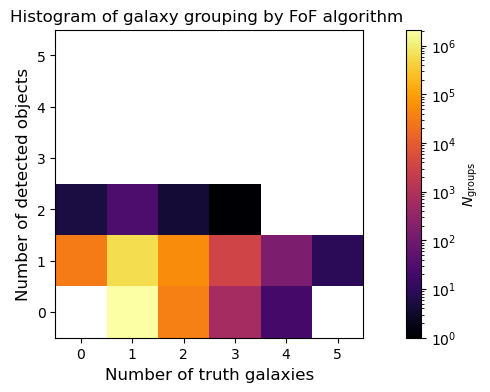

In [127]:
plt.figure(figsize=(11,4))
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5,
                   norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxy grouping by FoF algorithm ')
plt.savefig('halo_mass_z_cut_plot/Histogram of galaxy grouping by FoF algorithm ')
plt.show()

# Central galaxies selection :

In [23]:
ind_galax=np.array(results[truth_mask][:]['row_index'])  #transfo dictio astropy en array pour pouvoir indexer en gardant l'ordre des indices donné dans results (relié au group_id)

In [24]:
results[truth_mask]

row_index,catalog_key,group_id
int64,str6,int64
2052843,galaxy,0
488380,galaxy,1
485146,galaxy,2
640538,galaxy,3
665906,galaxy,4
795342,galaxy,5
642663,galaxy,6
732008,galaxy,7
1937653,galaxy,8


In [25]:
ind_galax_central = truth_data['is_central'][ind_galax]  #donne indices des galaxies centrales dans l'ordre de results (par groupe_id)

In [26]:
n_truth_central=np.bincount(results[truth_mask][ind_galax_central]['group_id'], minlength=n_groups)  #donne nbr groupe de galaxies cenrtales et leurs id sur la len de n_group

In [27]:
print('nbr of group with at list 1 central galaxies = ', len(n_truth_central[n_truth_central>0]), "(", (len(n_truth[n_truth_central>0])/n_groups)*100, '%)')

nbr of group with at list 1 central galaxies =  2589936 ( 90.7904326253491 %)


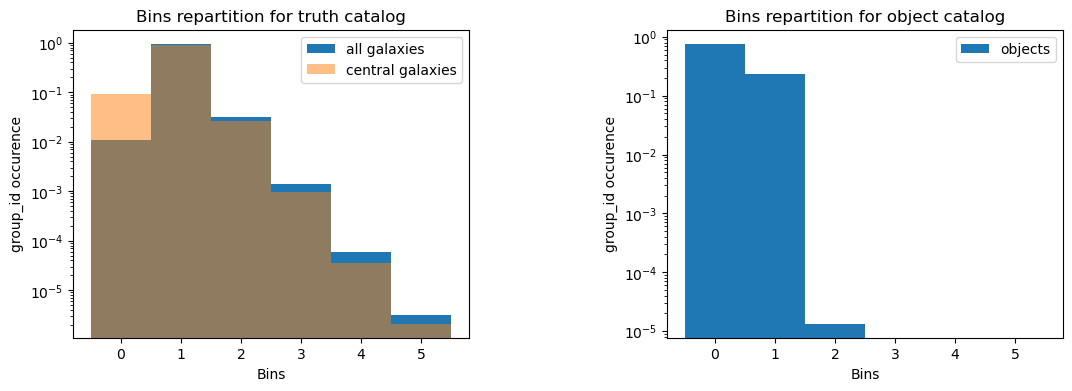

In [28]:
plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist1central=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2central=plt.hist(n_truth_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True, label='central galaxies')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for truth catalog')

plt2=plt.subplot(122)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for object catalog')

#plt.savefig('halo_mass_z_cut_plot/Bins repartition for object truth catalog.png')
plt.show()

Normalised histogram. When we remove satellite galaxies, we can observe a small increase in unrelated object.  

In [29]:
print(hist1central[0])
print(hist2central[0])

[1.06914511e-02 9.56181842e-01 3.16880462e-02 1.37661328e-03
 5.88925467e-05 3.15495786e-06]
[9.20956737e-02 8.81093845e-01 2.57973893e-02 9.75583080e-04
 3.54056382e-05 2.10330524e-06]


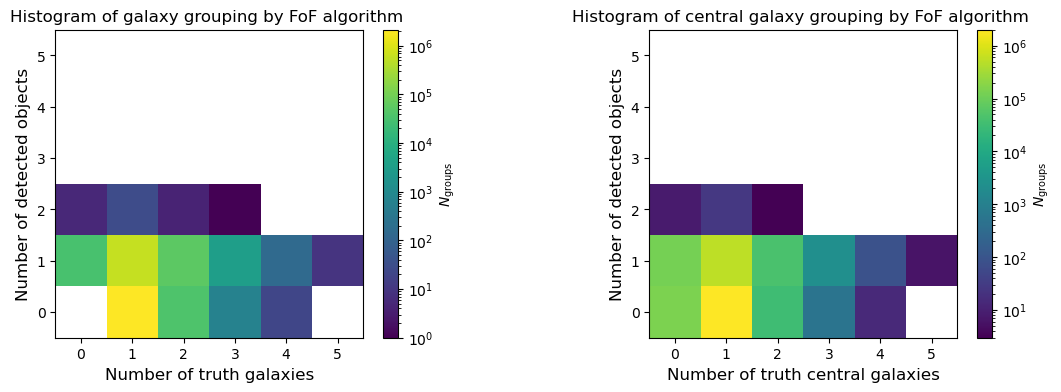

In [30]:
#average number of galaxies by groupsplt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm());

plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxy grouping by FoF algorithm ')

plt2=plt.subplot(122)
hist2d2central=plt.hist2d(n_truth_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth_central))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth central galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of central galaxy grouping by FoF algorithm ')

#plt.savefig('halo_mass_z_cut_plot/Histogram of central galaxy grouping by FoF algorithm.png')
plt.show()

Most of these systems are :

* 1-0 system : missed detection. Due to the mag cut (and thus the addition of fainter galaxies that are not matching with any object).
* 1-1 system : perfect match.

Note :

* Large number of systems (0-0) when galaxies satellite are removed.

* Slightly increase of systems (0-1) (ie, missed/error detection) for central galaxies.

* Emergence of systems (0-0), means what ?

Conclusion : 

Galaxies satellites sont généralement des isolated/fainter galaxies. Pas très précis => faire 1ere coupure avec halo masse pour se mettre dans régime des amas, regarder les galaxies satellites. 

In [31]:
print(hist2d1[0][:,0])
print(hist2d2central[0][:,0])

[0.000000e+00 2.139766e+06 3.553300e+04 6.580000e+02 2.100000e+01
 0.000000e+00]
[1.443030e+05 2.000672e+06 3.047500e+04 5.140000e+02 1.400000e+01
 0.000000e+00]


In [32]:
hist2d2central[0]

array([[1.443030e+05, 1.184060e+05, 8.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.000672e+06, 5.127560e+05, 2.700000e+01, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [3.047500e+04, 4.311300e+04, 3.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [5.140000e+02, 2.269000e+03, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.400000e+01, 8.700000e+01, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 6.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [33]:
#on ne prend pas en compte les erreurs de mesures (1ère colonne)

print(hist2d2central[0][2,1]) #nbr 2-1 system, unrecognized blend
print(hist2d2central[0][2,1:]) #nbr unrecognized blend
print(hist2d2central[0][:,1:])
print(hist2d2central[0][2,1])

43113.0
[4.3113e+04 3.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
[[1.18406e+05 8.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [5.12756e+05 2.70000e+01 0.00000e+00 0.00000e+00 0.00000e+00]
 [4.31130e+04 3.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [2.26900e+03 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [8.70000e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [6.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]]
43113.0


In [34]:
nbr_tot_syst_21=hist2d1[0][2,1]
nbr_syst_21_centr=hist2d2central[0][2,1]

print("% of system 2-1 for all galaxies =", (nbr_tot_syst_21/n_groups)*100)

print("% of system 2-1 with central galaxies in all existing 2-1 system =", (nbr_syst_21_centr/nbr_tot_syst_21)*100 )

% of system 2-1 for all galaxies = 1.9230519800340244
% of system 2-1 with central galaxies in all existing 2-1 system = 78.59017827846439


In [35]:
print("% of system 1-1 for all galaxies =", (hist2d1[0][1,1]/n_groups)*100)

print("% of system 1-1 with central galaxies in all existing 1-1 systems =", (hist2d2central[0][1,1]/hist2d1[0][1,1])*100 )

% of system 1-1 for all galaxies = 20.607518685237917
% of system 1-1 with central galaxies in all existing 1-1 systems = 87.22402064433598


In [36]:
print("% of unrecognized blend groups for all galaxies =", (np.sum(hist2d1[0][2:,1])/n_groups)*100)

print("% of unrecognized blend groups for central galaxies =", (np.sum(hist2d2central[0][2:,1])/n_groups)*100)

print('% of objects belonging to n-1 system for all galaxies =', (np.sum(hist2d1[0][2:,1])/len(truth_data['ra']))*100)

print('% of objects belonging to n-1 system for central galaxies =', (np.sum(hist2d2central[0][2:,1])/len(truth_data['ra']))*100)

% of unrecognized blend groups for all galaxies = 2.0430805990073098
% of unrecognized blend groups for central galaxies = 1.5941300957389488
% of objects belonging to n-1 system for all galaxies = 1.9953145268497194
% of objects belonging to n-1 system for central galaxies = 1.5568602331507324


In [37]:
print("nbr of 2-1 system for central galaxies :", hist2d2central[0][2,1])

print("nbr of 1-1 system for central galaxies :", hist2d2central[0][1,1])

nbr of 2-1 system for central galaxies : 43113.0
nbr of 1-1 system for central galaxies : 512756.0


### Satellite galaxies selection :

In [38]:
ind_galax_sat = ~ind_galax_central  #donne indices des galaxies satellites dans l'ordre de results (par groupe_id)

In [39]:
n_truth_sat=np.bincount(results[truth_mask][ind_galax_sat]['group_id'], minlength=n_groups)

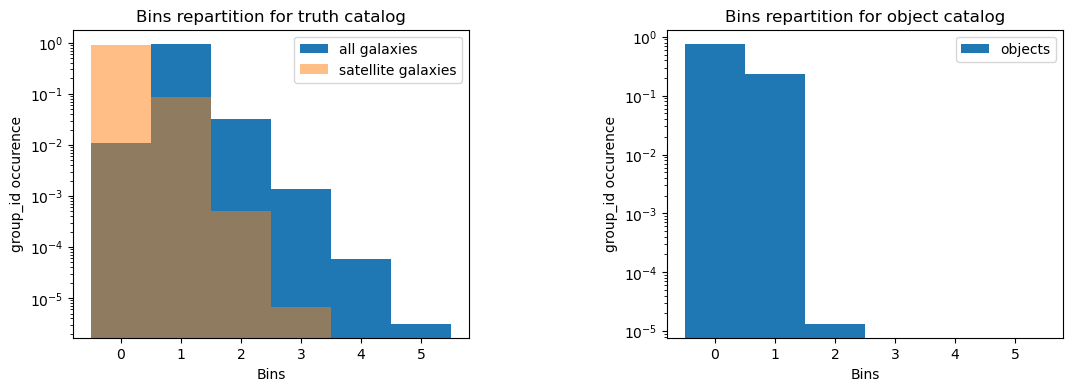

In [40]:
plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist1s=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2s=plt.hist(n_truth_sat, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True, label='satellite galaxies')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for truth catalog')

plt2=plt.subplot(122)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for object catalog')

#plt.savefig('Bins repartition for object truth catalog for sat galaxies.png')
plt.show()

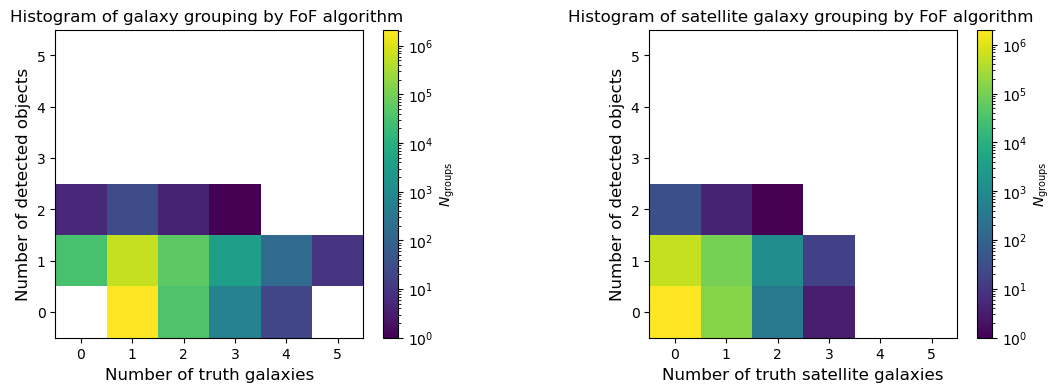

In [41]:
#average number of galaxies by groups : plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm());

plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxy grouping by FoF algorithm ')

plt2=plt.subplot(122)
hist2d2sat=plt.hist2d(n_truth_sat, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth satellite galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of satellite galaxy grouping by FoF algorithm ')

plt.savefig('halo_mass_z_cut_plot/Histogram of satellite galaxy grouping by FoF algorithm.png')
plt.show()

#attention histo en échelles log

Note :

Plus gros groupes disparaissent => ils sont composés plutôt de galaxies centrales 

In [42]:
print("% of system 2-1 with satellite galaxies in all existing 2-1 system =", (hist2d2sat[0][2,1]/nbr_tot_syst_21)*100 )

print("nbr of system 2-1 with satellite galaxies =", hist2d2sat[0][2,1])

% of system 2-1 with satellite galaxies in all existing 2-1 system = 2.0124685551788253
nbr of system 2-1 with satellite galaxies = 1104.0


In [43]:
print("% of system 1-1 with central galaxies in all existing 1-1 systems =", (hist2d2sat[0][1,1]/hist2d1[0][1,1])*100 )

print("nbr of system 1-1 with satellite galaxies =", hist2d2sat[0][1,1])

% of system 1-1 with central galaxies in all existing 1-1 systems = 16.94124971719505
nbr of system 1-1 with satellite galaxies = 99591.0


In [44]:
print("% of system 1-1 for all galaxies =", (hist2d1[0][1,1]/n_groups)*100)

print("% of system 1-1 for satellite galaxies =", (hist2d2sat[0][1,1]/np.sum(hist2d2sat[0][:,1:]))*100 )

% of system 1-1 for all galaxies = 20.607518685237917
% of system 1-1 for satellite galaxies = 14.717700520929544


In [45]:
print("% of unrecognized blend groups for satellite galaxies =", (np.sum(hist2d2sat[0][2:,1])/n_groups)*100)

print('% of objects belonging to n-1 system for satellite galaxies =', (np.sum(hist2d2sat[0][2:,1])/len(truth_data['ra']))*100)

% of unrecognized blend groups for satellite galaxies = 0.03926169779499995
% of objects belonging to n-1 system for satellite galaxies = 0.038343781443184614


# Halo Mass Cut : 

## 1e14 cut :

In [46]:
halo_mass_cut=1e14

### Study mass cut 1e14 for all galaxies :

In [47]:
#selection toutes les galaxies de masse > halo_mass_cut_choisie

results[truth_mask][np.where(truth_data['halo_mass'][ind_galax]>halo_mass_cut)[0]]

row_index,catalog_key,group_id
int64,str6,int64
524634,galaxy,6513
524611,galaxy,7021
524593,galaxy,7851
524554,galaxy,7891
524542,galaxy,8256
607165,galaxy,22249
607240,galaxy,22523
613030,galaxy,22609
607157,galaxy,22631


In [48]:
n_truth_halo_mass_cut_all = np.bincount(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax]>halo_mass_cut)[0]]['group_id'],
                                    minlength=n_groups)

In [49]:
print('nbr of groups with at least 1 galaxies with mass >1e14 = ', len(n_truth_halo_mass_cut_all[n_truth_halo_mass_cut_all>0]),
      '(', 100*len(n_truth_halo_mass_cut_all[n_truth_halo_mass_cut_all>0])/n_groups, '% of the totality of truth galaxies)')

nbr of groups with at least 1 galaxies with mass >1e14 =  4504 ( 0.15788811327560695 % of the totality of truth galaxies)


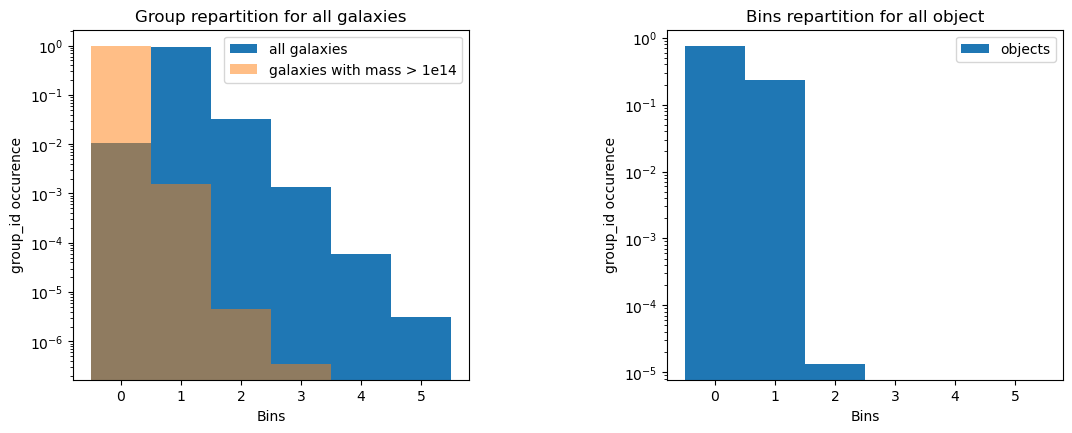

In [50]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_halo_mass_cut_all, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'galaxies with mass > 1e14')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Group repartition for all galaxies')

plt2=plt.subplot(222)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

#plt.savefig('Bins repartition for all object truth galaxies with mass 1e14')
plt.show()

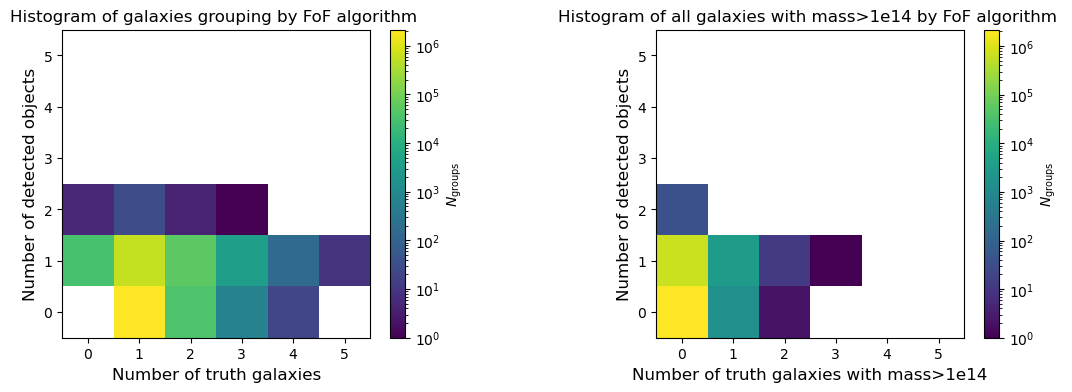

In [51]:
#average number of galaxies by groups : plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm());

plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(122)
hist2d2_mass_14_all=plt.hist2d(n_truth_halo_mass_cut_all, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies with mass>1e14', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all galaxies with mass>1e14 by FoF algorithm ')

#plt.savefig('Histogram of all galaxies with mass>1e14 by FoF algorithm ')
plt.show()

In [52]:
print("recognized blending :")

print("nbr of (1-0) systems =", hist2d2_mass_14_all[0][1,0])

print("nbr of (1-1) systems =", hist2d2_mass_14_all[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_mass_14_all[0][2,1])

recognized blending :
nbr of (1-0) systems = 1420.0
nbr of (1-1) systems = 3070.0
unrecognized blending :
nbr of (2-1) systems = 11.0


In [53]:
print("% of (1-0) systems in all galaxies with a mass > 1e14 :",
     (hist2d2_mass_14_all[0][1,0]/len(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax]>halo_mass_cut)[0]]))*100)

print("% of (1-1) systems in all galaxies with a mass > 1e14 :",
     (hist2d2_mass_14_all[0][1,1]/len(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax]>halo_mass_cut)[0]]))*100)

print("% of (2-1) systems in all galaxies with a mass > 1e14 :",
     (hist2d2_mass_14_all[0][2,1]/len(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax]>halo_mass_cut)[0]]))*100)

% of (1-0) systems in all galaxies with a mass > 1e14 : 31.422881168400092
% of (1-1) systems in all galaxies with a mass > 1e14 : 67.93538393449879
% of (2-1) systems in all galaxies with a mass > 1e14 : 0.24341668510732464


### Study mass cut 1e14 for central galaxies :

In [54]:
#selection galaxies centrales (=halo) de masse > halo_mass_cut_choisit parmis toutes les galaxies centrales (qui, dans la simu, sont toutes des halos)

results[truth_mask][ind_galax_central][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>halo_mass_cut)[0]]

row_index,catalog_key,group_id
int64,str6,int64
607124,galaxy,28907
383233,galaxy,77080
2720785,galaxy,89578
1829506,galaxy,119055
824286,galaxy,202373
612730,galaxy,202968
521328,galaxy,203232
606976,galaxy,217324
738969,galaxy,282310


In [55]:
n_truth_halo_mass_cut_central = np.bincount(results[truth_mask][ind_galax_central][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>halo_mass_cut)[0]]['group_id'],
                                    minlength=n_groups)

In [56]:
print('nbr of groups with at least 1 central galaxies with mass >1e14 = ', len(n_truth_halo_mass_cut_central[n_truth_halo_mass_cut_central>0]),
      '(', 100*len(n_truth_halo_mass_cut_central[n_truth_halo_mass_cut_central>0])/n_groups, '% of the totality of truth galaxies)')

nbr of groups with at least 1 central galaxies with mass >1e14 =  30 ( 0.0010516526195089274 % of the totality of truth galaxies)


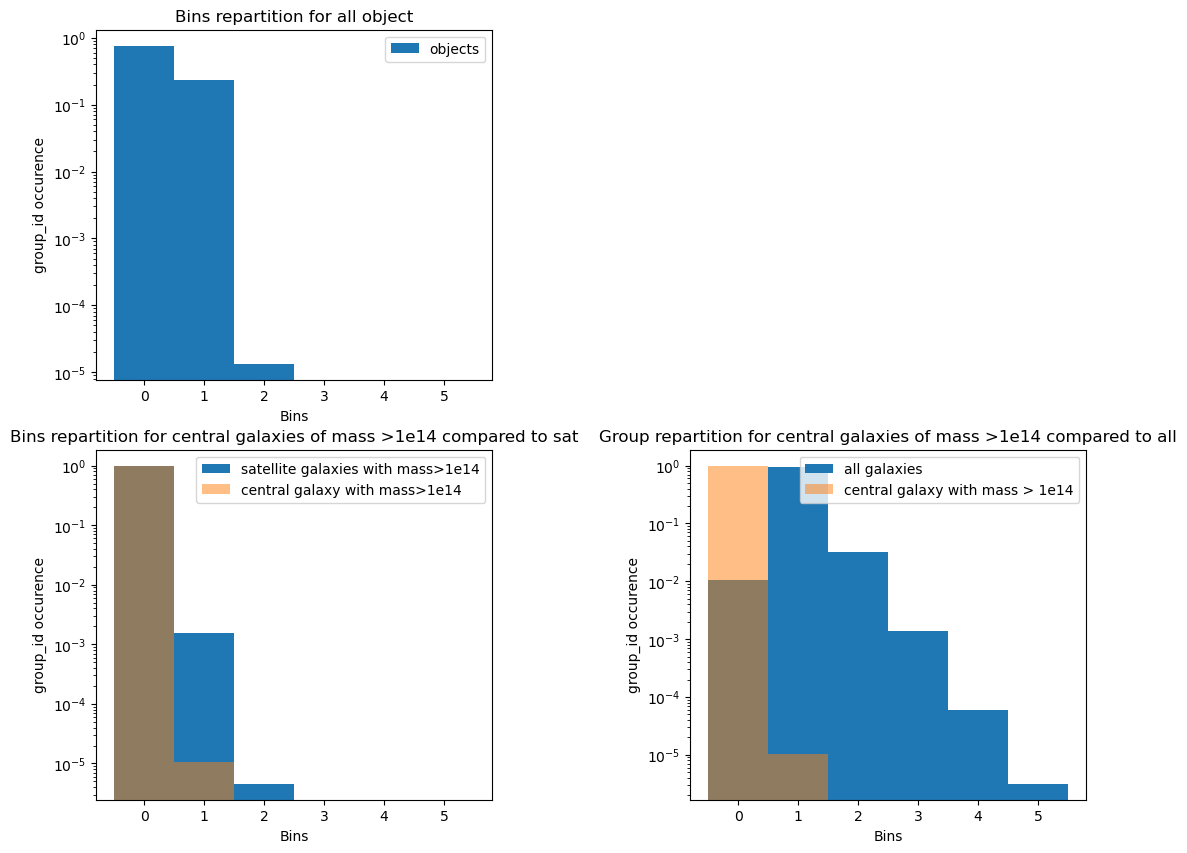

In [57]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(224)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_halo_mass_cut_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'central galaxy with mass > 1e14')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Group repartition for central galaxies of mass >1e14 compared to all')

plt2=plt.subplot(221)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

plt3=plt.subplot(223)
n_truth_halo_mass_cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut)[0]]['group_id'],
                                    minlength=n_groups)
hist1mass=plt.hist(n_truth_halo_mass_cut_sat, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="satellite galaxies with mass>1e14")
hist2mass=plt.hist(n_truth_halo_mass_cut_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'central galaxy with mass>1e14 ')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for central galaxies of mass >1e14 compared to sat')

#plt.savefig('Bins repartition for central galaxies of mass >1e14 compared to sat and all galaxies')
plt.show()

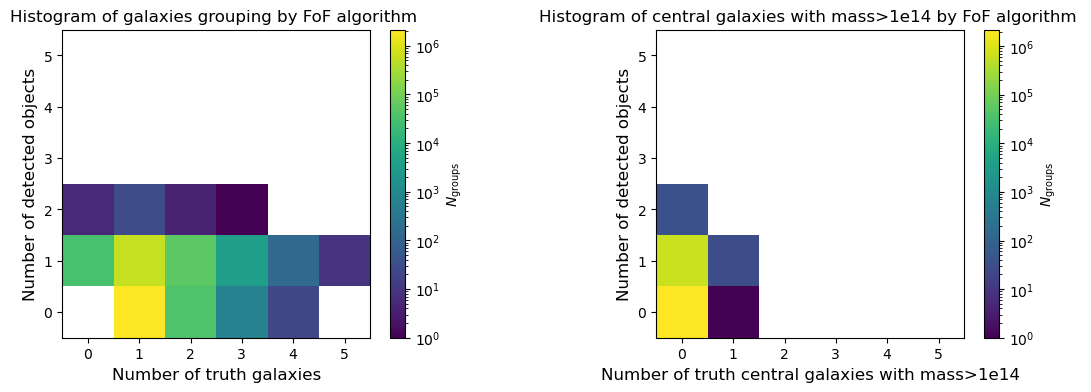

In [58]:
#average number of galaxies by groups : plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm());

plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(122)
hist2d2_mass_14_central=plt.hist2d(n_truth_halo_mass_cut_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth central galaxies with mass>1e14', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of central galaxies with mass>1e14 by FoF algorithm ')

#plt.savefig('Histogram of central galaxies with mass>1e14 by FoF algorithm')
plt.show()

In [59]:
print("recognized blending :")

print("nbr of (1-0) systems =", hist2d2_mass_14_central[0][1,0])

print("nbr of (1-1) systems =", hist2d2_mass_14_central[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_mass_14_central[0][2,1])

recognized blending :
nbr of (1-0) systems = 1.0
nbr of (1-1) systems = 29.0
unrecognized blending :
nbr of (2-1) systems = 0.0


Pas (ou très peu) de blending sur les galaxies centrales logique car étant très brillante elles sont moins affectés par le blending

In [60]:
print("% of (1-0) systems in central galaxies with a mass > 1e14 :",
     (hist2d2_mass_14_central[0][1,0]/len(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>halo_mass_cut)[0]]))*100)

print("% of (1-1) systems in central galaxies with a mass > 1e14 :",
     (hist2d2_mass_14_central[0][1,1]/len(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>halo_mass_cut)[0]]))*100)

print("% of (2-1) systems in central galaxies with a mass > 1e14 :",
     (hist2d2_mass_14_central[0][2,1]/len(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>halo_mass_cut)[0]]))*100)

% of (1-0) systems in central galaxies with a mass > 1e14 : 3.3333333333333335
% of (1-1) systems in central galaxies with a mass > 1e14 : 96.66666666666667
% of (2-1) systems in central galaxies with a mass > 1e14 : 0.0


### Study mass cut 1e14 for satellite galaxies :

In [61]:
#selection galaxies satellites de masse > halo_mass_cut_choisit parmis toutes les galaxies satellites

results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut)[0]]

row_index,catalog_key,group_id
int64,str6,int64
524634,galaxy,6513
524611,galaxy,7021
524593,galaxy,7851
524554,galaxy,7891
524542,galaxy,8256
607165,galaxy,22249
607240,galaxy,22523
613030,galaxy,22609
607157,galaxy,22631


In [62]:
n_truth_halo_mass_cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut)[0]]['group_id'],
                                    minlength=n_groups)

In [63]:
print('nbr of groups with at least 1 central galaxies with mass >1e14 = ', len(n_truth_halo_mass_cut_sat[n_truth_halo_mass_cut_sat>0]),
      '(', 100*len(n_truth_halo_mass_cut_sat[n_truth_halo_mass_cut_sat>0])/n_groups, '% of the totality of all truth galaxies)')

nbr of groups with at least 1 central galaxies with mass >1e14 =  4476 ( 0.15690657083073195 % of the totality of all truth galaxies)


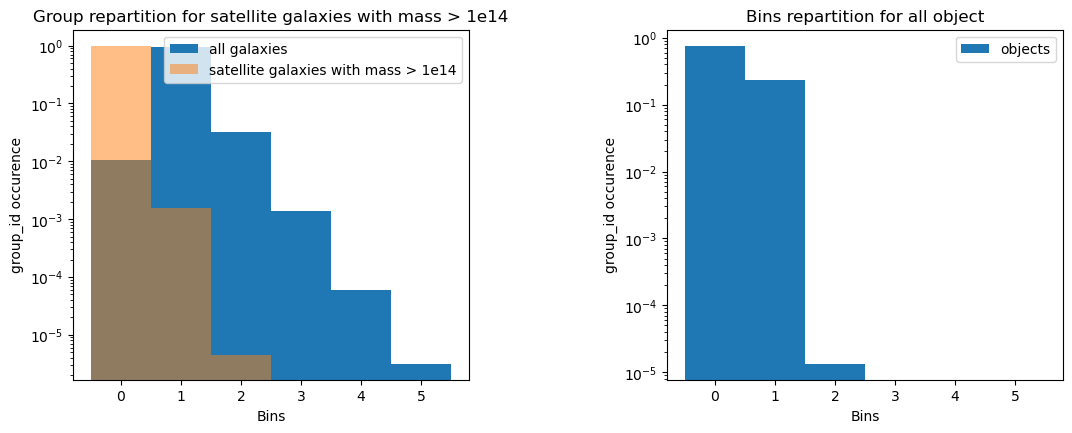

In [64]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_halo_mass_cut_sat, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'satellite galaxies with mass > 1e14')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Group repartition for satellite galaxies with mass > 1e14')

plt2=plt.subplot(222)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

#plt.savefig('Group repartition for satellite galaxies with mass > 1e14')
plt.show()

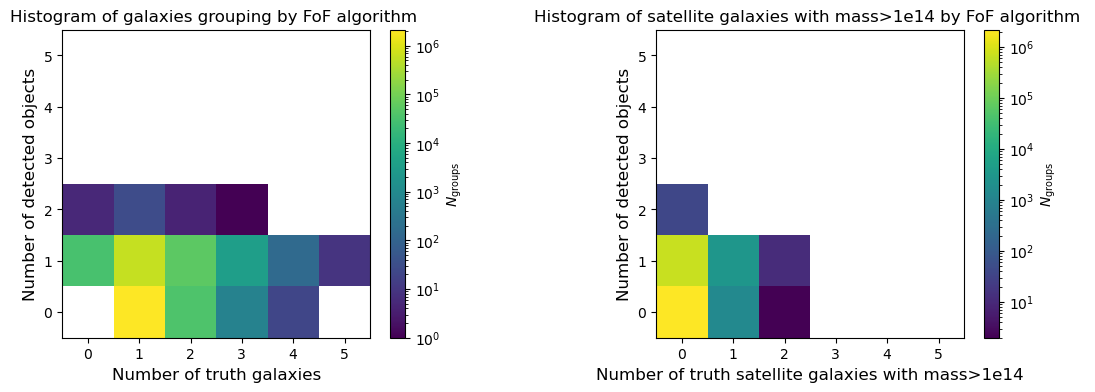

In [65]:
#average number of galaxies by groups : plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm());

plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(122)
hist2d2_mass_14_sat=plt.hist2d(n_truth_halo_mass_cut_sat, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth satellite galaxies with mass>1e14', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of satellite galaxies with mass>1e14 by FoF algorithm ')

#plt.savefig('halo_mass_z_cut_plot/Histogram of satellite galaxies with mass>1e14 by FoF algorithm')
plt.show()

In [66]:
print("recognized blending :")

print("nbr of (1-0) systems =", hist2d2_mass_14_sat[0][1,0])

print("nbr of (1-1) systems =", hist2d2_mass_14_sat[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_mass_14_sat[0][2,1])

recognized blending :
nbr of (1-0) systems = 1419.0
nbr of (1-1) systems = 3044.0
unrecognized blending :
nbr of (2-1) systems = 11.0


In [67]:
print("% of (1-0) systems in central galaxies with a mass > 1e14 :",
     (hist2d2_mass_14_sat[0][1,0]/len(results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut)[0]]))*100)

print("% of (1-1) systems in central galaxies with a mass > 1e14 :",
     (hist2d2_mass_14_sat[0][1,1]/len(results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut)[0]]))*100)

print("% of (2-1) systems in all galaxies with a mass > 1e14 :",
     (hist2d2_mass_14_sat[0][2,1]/len(results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut)[0]]))*100)

% of (1-0) systems in central galaxies with a mass > 1e14 : 31.61060369792827
% of (1-1) systems in central galaxies with a mass > 1e14 : 67.8102027177545
% of (2-1) systems in all galaxies with a mass > 1e14 : 0.24504343951882382


# Halo Mass Cut : 1e13

In [68]:
halo_mass_cut2=1e13

## Study mass cut 1e13 for all galaxies :

In [69]:
n_truth_halo_mass_cut13_all = np.bincount(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax]>halo_mass_cut2)[0]]['group_id'],
                                    minlength=n_groups)

In [70]:
results[truth_mask][np.where(truth_data['halo_mass'][ind_galax]>halo_mass_cut2)[0]]

row_index,catalog_key,group_id
int64,str6,int64
2352568,galaxy,119
2352562,galaxy,129
449081,galaxy,155
2864139,galaxy,327
2346214,galaxy,356
2346232,galaxy,425
1877494,galaxy,535
1877504,galaxy,557
2046346,galaxy,695


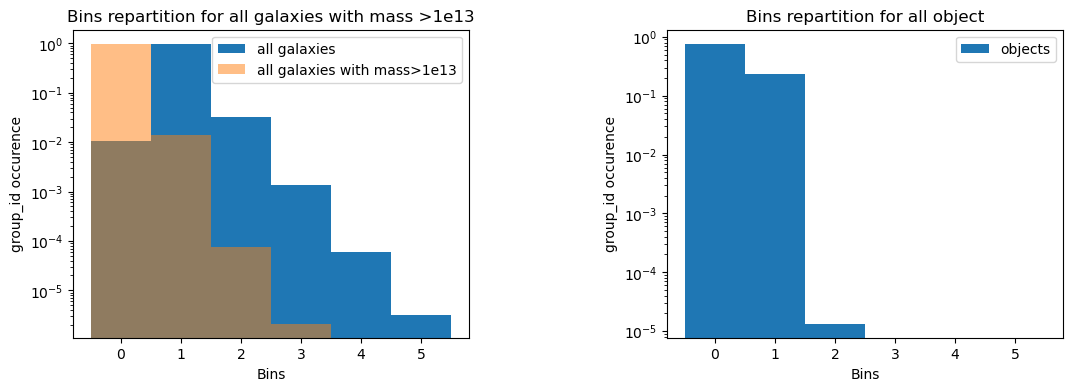

In [71]:
plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_halo_mass_cut13_all, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'all galaxies with mass>1e13')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all galaxies with mass >1e13')

plt2=plt.subplot(122)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

#plt.savefig('halo_mass_z_cut_plot/Bins repartition for all galaxies with mass >1e13 and object')
plt.show()

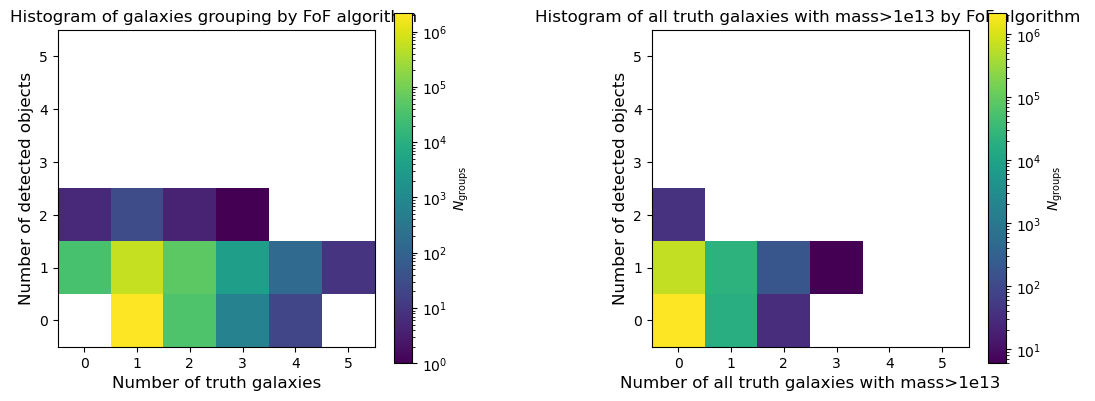

In [72]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_mass_13_all=plt.hist2d(n_truth_halo_mass_cut13_all, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of all truth galaxies with mass>1e13', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all truth galaxies with mass>1e13 by FoF algorithm ')

#plt.savefig('halo_mass_z_cut_plot/Histogram of all truth galaxies with mass>1e13 by FoF algorithm')
plt.show()

In [73]:
print("missed detections :")

print("nbr of (1-0) systems for galaxies with mass > 1e13 =", hist2d2_mass_13_all[0][1,0])

print("nbr of (1-0) systems for galaxies with mass > 1e14 =", hist2d2_mass_14_all[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_mass_13_all[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_mass_13_all[0][2,1])

print("nbr of (3-1) systems =", hist2d2_mass_13_all[0][3,1])

missed detections :
nbr of (1-0) systems for galaxies with mass > 1e13 = 18458.0
nbr of (1-0) systems for galaxies with mass > 1e14 = 1420.0
recognized blending :
nbr of (1-1) systems = 22208.0
unrecognized blending :
nbr of (2-1) systems = 188.0
nbr of (3-1) systems = 6.0


In [74]:
print("% of (1-0) systems in all truth galaxies with a mass > 1e13 :",
     (hist2d2_mass_13_all[0][1,0]/len(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax]>halo_mass_cut2)[0]]))*100)

print("% of (1-0) systems in all truth galaxies with a mass > 1e14 :",
     (hist2d2_mass_14_all[0][1,0]/len(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax]>halo_mass_cut)[0]]))*100)

print("% of (1-1) systems in all truth galaxies with a mass > 1e13 :",
     (hist2d2_mass_13_all[0][1,1]/len(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax]>halo_mass_cut2)[0]]))*100)

print("% of (2-1) systems in all truth galaxies with a mass > 1e13 :",
     (hist2d2_mass_13_all[0][2,1]/len(results[truth_mask][np.where(truth_data['halo_mass'][ind_galax]>halo_mass_cut2)[0]]))*100)

% of (1-0) systems in all truth galaxies with a mass > 1e13 : 44.88594912698799
% of (1-0) systems in all truth galaxies with a mass > 1e14 : 31.422881168400092
% of (1-1) systems in all truth galaxies with a mass > 1e13 : 54.00515539127474
% of (2-1) systems in all truth galaxies with a mass > 1e13 : 0.45717620738290937


## Study mass cut 1e13 for central galaxies :

In [75]:
n_truth_halo_mass_cut13_central = np.bincount(results[truth_mask][ind_galax_central][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>halo_mass_cut2)[0]]['group_id'],
                                    minlength=n_groups)

In [76]:
results[truth_mask][ind_galax_central][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>halo_mass_cut2)[0]]

row_index,catalog_key,group_id
int64,str6,int64
2352562,galaxy,129
2260593,galaxy,1947
1771174,galaxy,2290
2346201,galaxy,3795
1765588,galaxy,3802
2242088,galaxy,3888
2210313,galaxy,4041
2254747,galaxy,4241
1877492,galaxy,4368


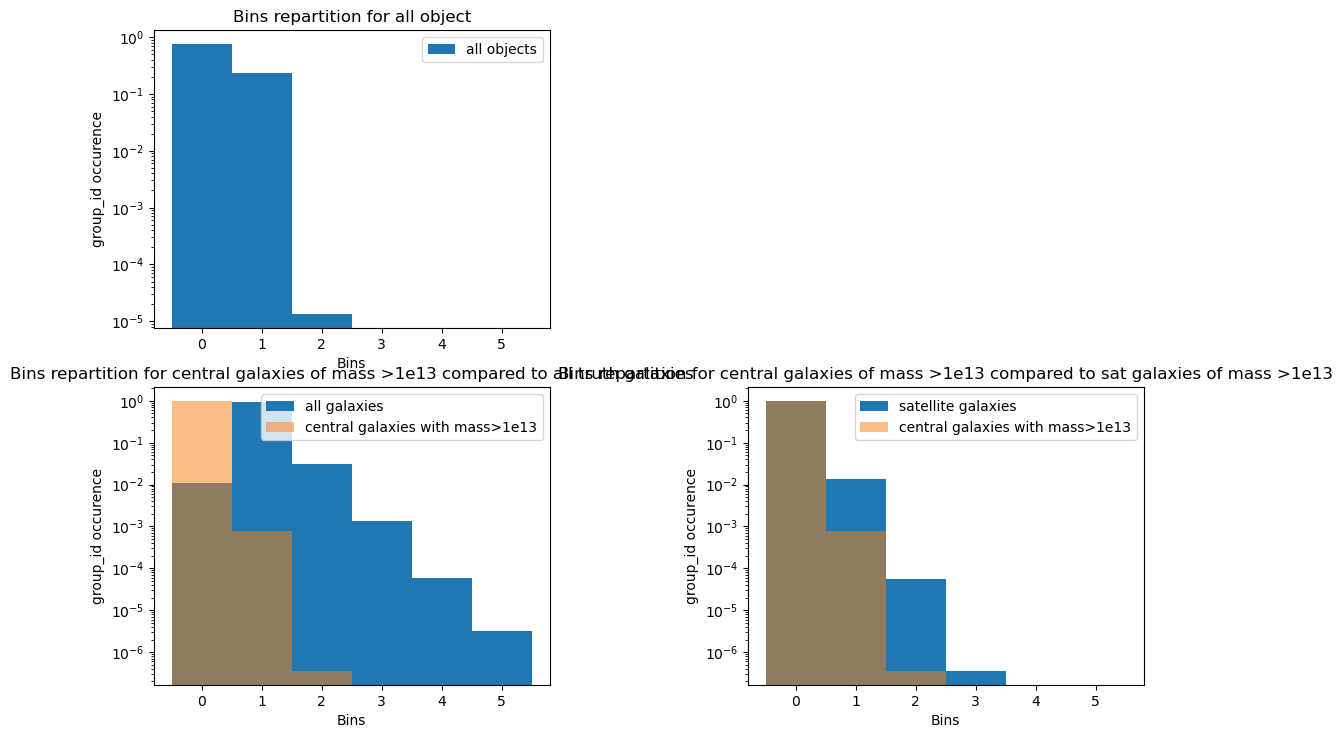

In [77]:
plt.figure(figsize=(11,8.5))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(223)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_halo_mass_cut13_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'central galaxies with mass>1e13')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for central galaxies of mass >1e13 compared to all truth galaxies')

plt2=plt.subplot(221)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

plt3=plt.subplot(224)
n_truth_halo_mass_cut13_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut2)[0]]['group_id'],
                                    minlength=n_groups)
hist1mass=plt.hist(n_truth_halo_mass_cut13_sat, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="satellite galaxies")
hist2mass=plt.hist(n_truth_halo_mass_cut13_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'central galaxies with mass>1e13')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for central galaxies of mass >1e13 compared to sat galaxies of mass >1e13')

#plt.savefig('halo_mass_z_cut_plot/Bins repartition for central galaxies of mass >1e13')
plt.show()

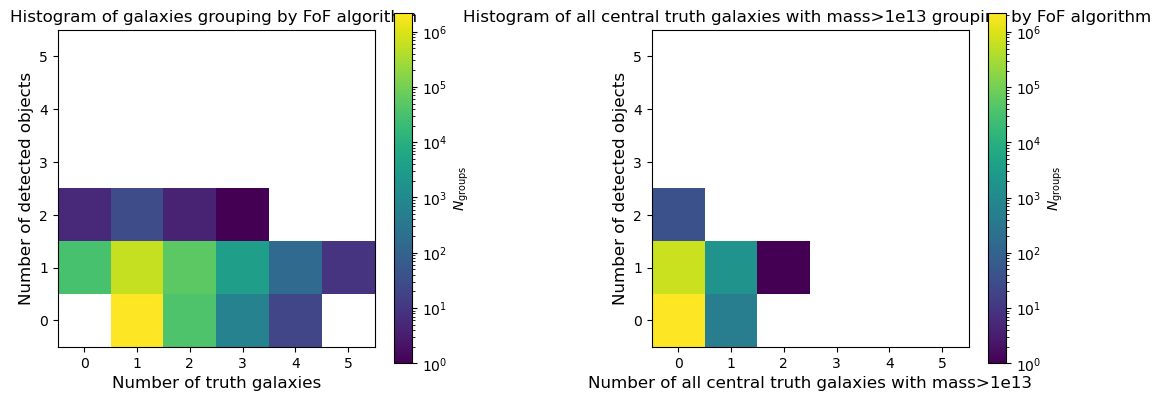

In [78]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt3=plt.subplot(222)
hist2d2_mass_13_central=plt.hist2d(n_truth_halo_mass_cut13_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of all central truth galaxies with mass>1e13', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all central truth galaxies with mass>1e13 grouping by FoF algorithm ')

#plt.savefig('halo_mass_z_cut_plot/Histogram of all central truth galaxies with mass>1e13 grouping by FoF algorithm')
plt.show()

In [79]:
print("missed detections :")

print("nbr of (1-0) systems for galaxies with mass > 1e13 =", hist2d2_mass_13_central[0][1,0])

print("nbr of (1-0) systems for galaxies with mass > 1e14 =", hist2d2_mass_14_central[0][1,0])


print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_mass_13_central[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_mass_13_central[0][2,1])

missed detections :
nbr of (1-0) systems for galaxies with mass > 1e13 = 455.0
nbr of (1-0) systems for galaxies with mass > 1e14 = 1.0
recognized blending :
nbr of (1-1) systems = 1765.0
unrecognized blending :
nbr of (2-1) systems = 1.0


In [80]:
print("% of (1-0) systems in all central truth galaxies with a mass > 1e13 :",
     (hist2d2_mass_13_central[0][1,0]/len(results[truth_mask][ind_galax_central][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>halo_mass_cut2)[0]]))*100)

print("% of (1-1) systems in all central truth galaxies with a mass > 1e13 :",
     (hist2d2_mass_13_central[0][1,1]/len(results[truth_mask][ind_galax_central][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>halo_mass_cut2)[0]]))*100)

print("% of (2-1) systems in all central truth galaxies with a mass > 1e13 :",
     (hist2d2_mass_13_central[0][2,1]/len(results[truth_mask][ind_galax_central][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>halo_mass_cut2)[0]]))*100)

% of (1-0) systems in all central truth galaxies with a mass > 1e13 : 20.477047704770477
% of (1-1) systems in all central truth galaxies with a mass > 1e13 : 79.43294329432943
% of (2-1) systems in all central truth galaxies with a mass > 1e13 : 0.045004500450045004


## Study mass cut 1e13 for satellite truth galaxies :

In [81]:
n_truth_halo_mass_cut13_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut2)[0]]['group_id'],
                                    minlength=n_groups)

In [82]:
results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut2)[0]]

row_index,catalog_key,group_id
int64,str6,int64
2352568,galaxy,119
449081,galaxy,155
2864139,galaxy,327
2346214,galaxy,356
2346232,galaxy,425
1877494,galaxy,535
1877504,galaxy,557
2046346,galaxy,695
2046360,galaxy,721


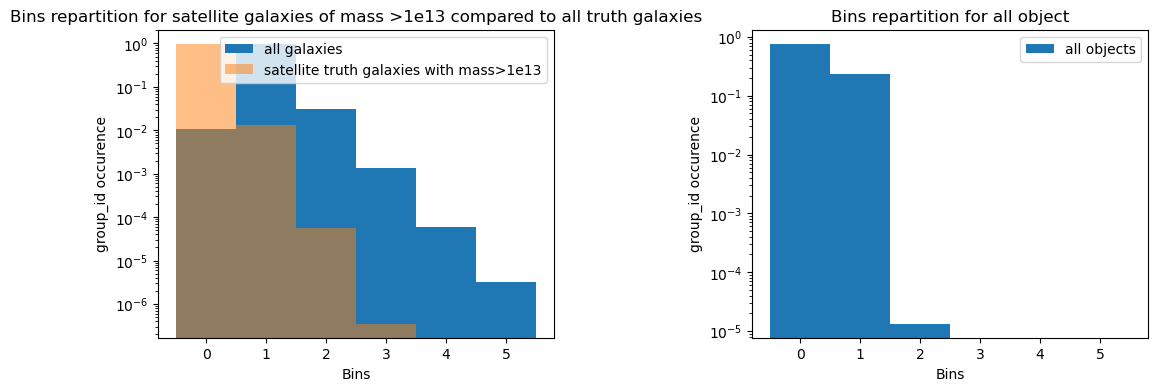

In [83]:
plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_halo_mass_cut13_sat, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'satellite truth galaxies with mass>1e13')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for satellite galaxies of mass >1e13 compared to all truth galaxies')

plt2=plt.subplot(122)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

#plt.savefig('Bins repartition for satellite galaxies of mass >1e13')
plt.show()

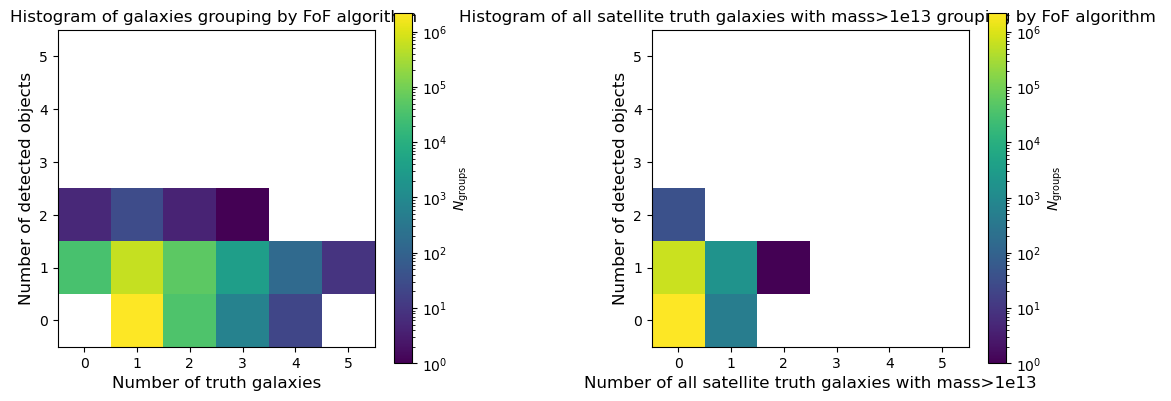

In [84]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt3=plt.subplot(222)
hist2d2_mass_13_sat=plt.hist2d(n_truth_halo_mass_cut13_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of all satellite truth galaxies with mass>1e13', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all satellite truth galaxies with mass>1e13 grouping by FoF algorithm ')


#plt.savefig('halo_mass_z_cut_plot/Histogram of all satellite truth galaxies with mass>1e13 grouping by FoF algorithm ')
plt.show()

In [85]:
print("missed detections :")

print("nbr of (1-0) systems for all satellite galaxies with mass > 1e13 =", hist2d2_mass_13_sat[0][1,0])

print("nbr of (1-0) systems for all satellite galaxies with mass > 1e14 =", hist2d2_mass_14_sat[0][1,0])


print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_mass_13_sat[0][1,1])


print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_mass_13_sat[0][2,1])

missed detections :
nbr of (1-0) systems for all satellite galaxies with mass > 1e13 = 455.0
nbr of (1-0) systems for all satellite galaxies with mass > 1e14 = 1419.0
recognized blending :
nbr of (1-1) systems = 1765.0
unrecognized blending :
nbr of (2-1) systems = 1.0


In [86]:
print("% of (1-0) systems in all satellite truth galaxies with a mass > 1e13 :",
     (hist2d2_mass_13_sat[0][1,0]/len(results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut2)[0]]))*100)

print("% of (1-1) systems in all satellite truth galaxies with a mass > 1e13 :",
     (hist2d2_mass_13_sat[0][1,1]/len(results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut2)[0]]))*100)

print("% of (2-1) systems in all satellite truth galaxies with a mass > 1e13 :",
     (hist2d2_mass_13_sat[0][2,1]/len(results[truth_mask][ind_galax_sat][np.where(truth_data['halo_mass'][ind_galax][ind_galax_sat]>halo_mass_cut2)[0]]))*100)

% of (1-0) systems in all satellite truth galaxies with a mass > 1e13 : 1.1696658097686374
% of (1-1) systems in all satellite truth galaxies with a mass > 1e13 : 4.5372750642673525
% of (2-1) systems in all satellite truth galaxies with a mass > 1e13 : 0.0025706940874035992


### Find the optimal mass cut : (ie, with the maximum recognized blend)

In [87]:
'''eps=0.2
exp=np.arange(13,14.5+eps, eps)
halo_mass=np.zeros(len(exp))
hist=np.zeros(len(exp))

for i in range (0,len(exp)):
    mass_cut= 10**(exp[i])
    halo_mass[i]=mass_cut
    #print(halo_mass[i])
    n_truth_halo_mass = np.bincount(results[truth_mask][ind_galax_central][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>mass_cut)[0]]['group_id'],
                                    minlength=n_groups)
    
    hist[i]=plt.hist2d(n_truth_halo_mass_cut, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())[0][1,1]
print(hist)'''

"eps=0.2\nexp=np.arange(13,14.5+eps, eps)\nhalo_mass=np.zeros(len(exp))\nhist=np.zeros(len(exp))\n\nfor i in range (0,len(exp)):\n    mass_cut= 10**(exp[i])\n    halo_mass[i]=mass_cut\n    #print(halo_mass[i])\n    n_truth_halo_mass = np.bincount(results[truth_mask][ind_galax_central][np.where(truth_data['halo_mass'][ind_galax][ind_galax_central]>mass_cut)[0]]['group_id'],\n                                    minlength=n_groups)\n    \n    hist[i]=plt.hist2d(n_truth_halo_mass_cut, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())[0][1,1]\nprint(hist)"

# Z-cut :

In [88]:
z_max_cut=1.5

## Study z-max-cut for all galaxies :

In [89]:
results[truth_mask][np.where(truth_data['redshift'][ind_galax]<z_max_cut)[0]]

row_index,catalog_key,group_id
int64,str6,int64
2052843,galaxy,0
488380,galaxy,1
485146,galaxy,2
640538,galaxy,3
665906,galaxy,4
795342,galaxy,5
642663,galaxy,6
732008,galaxy,7
1937653,galaxy,8


In [90]:
n_truth_z_max_cut_all = np.bincount(results[truth_mask][np.where(truth_data['redshift'][ind_galax]<z_max_cut)[0]]['group_id'],
                                    minlength=n_groups)

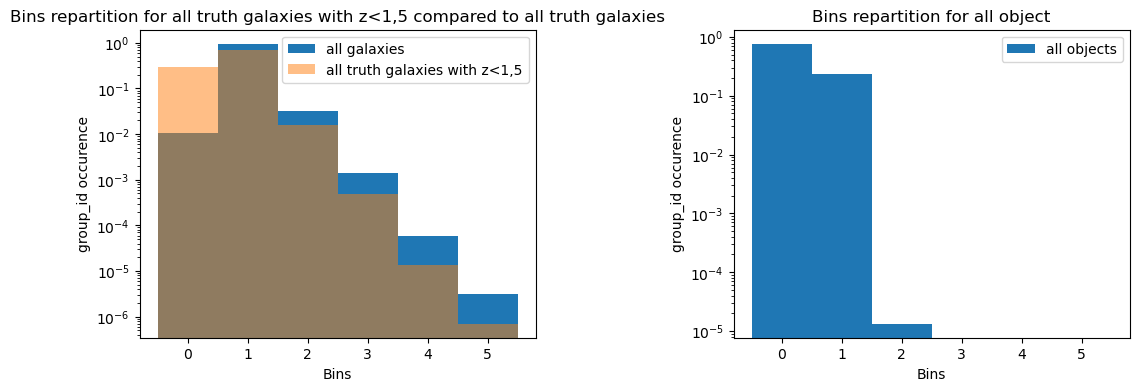

In [91]:
plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_z_max_cut_all, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'all truth galaxies with z<1,5')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all truth galaxies with z<1,5 compared to all truth galaxies')

plt2=plt.subplot(122)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

plt.show()

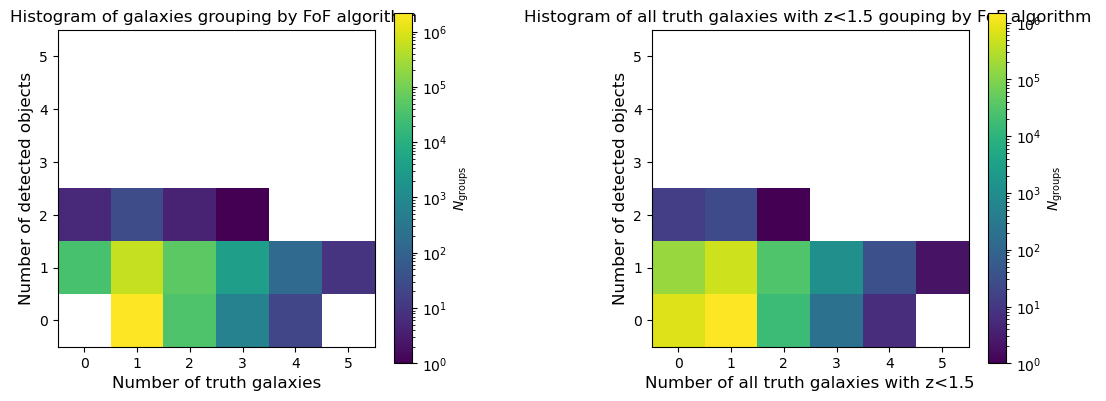

In [92]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_z_max_all=plt.hist2d(n_truth_z_max_cut_all, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of all truth galaxies with z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all truth galaxies with z<1.5 gouping by FoF algorithm ')

plt.show()

In [93]:
print("missed detections :")

print("nbr of (1-0) systems for all truth galaxies with z<1,5 =", hist2d2_z_max_all[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_z_max_all[0][1,1])


print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_z_max_all[0][2,1])

missed detections :
nbr of (1-0) systems for all truth galaxies with z<1,5 = 1455367.0
recognized blending :
nbr of (1-1) systems = 486715.0
unrecognized blending :
nbr of (2-1) systems = 29723.0


In [94]:
print("% of (1-0) systems in all truth galaxies with z<1,5 :",
     (hist2d2_z_max_all[0][1,0]/len(results[truth_mask][np.where(truth_data['redshift'][ind_galax]<z_max_cut)[0]]))*100)

print("% of (1-1) systems in all truth galaxies with z<1,5 :",
     (hist2d2_z_max_all[0][1,1]/len(results[truth_mask][np.where(truth_data['redshift'][ind_galax]<z_max_cut)[0]]))*100)

print("% of (2-1) systems in all truth galaxies with z<1,5 :",
     (hist2d2_z_max_all[0][2,1]/len(results[truth_mask][np.where(truth_data['redshift'][ind_galax]<z_max_cut)[0]]))*100)

% of (1-0) systems in all truth galaxies with z<1,5 : 71.41086515876447
% of (1-1) systems in all truth galaxies with z<1,5 : 23.881769502639575
% of (2-1) systems in all truth galaxies with z<1,5 : 1.458426050002478


## z-max-cut study for central galaxies :

In [95]:
results[truth_mask][ind_galax_central][np.where(truth_data['redshift'][ind_galax][ind_galax_central]<z_max_cut)[0]]

row_index,catalog_key,group_id
int64,str6,int64
2052843,galaxy,0
488380,galaxy,1
485146,galaxy,2
640538,galaxy,3
665906,galaxy,4
795342,galaxy,5
642663,galaxy,6
732008,galaxy,7
1937653,galaxy,8


In [96]:
n_truth_z_max_cut_central = np.bincount(results[truth_mask][ind_galax_central][np.where(truth_data['redshift'][ind_galax][ind_galax_central]<z_max_cut)[0]]['group_id'],
                                    minlength=n_groups)

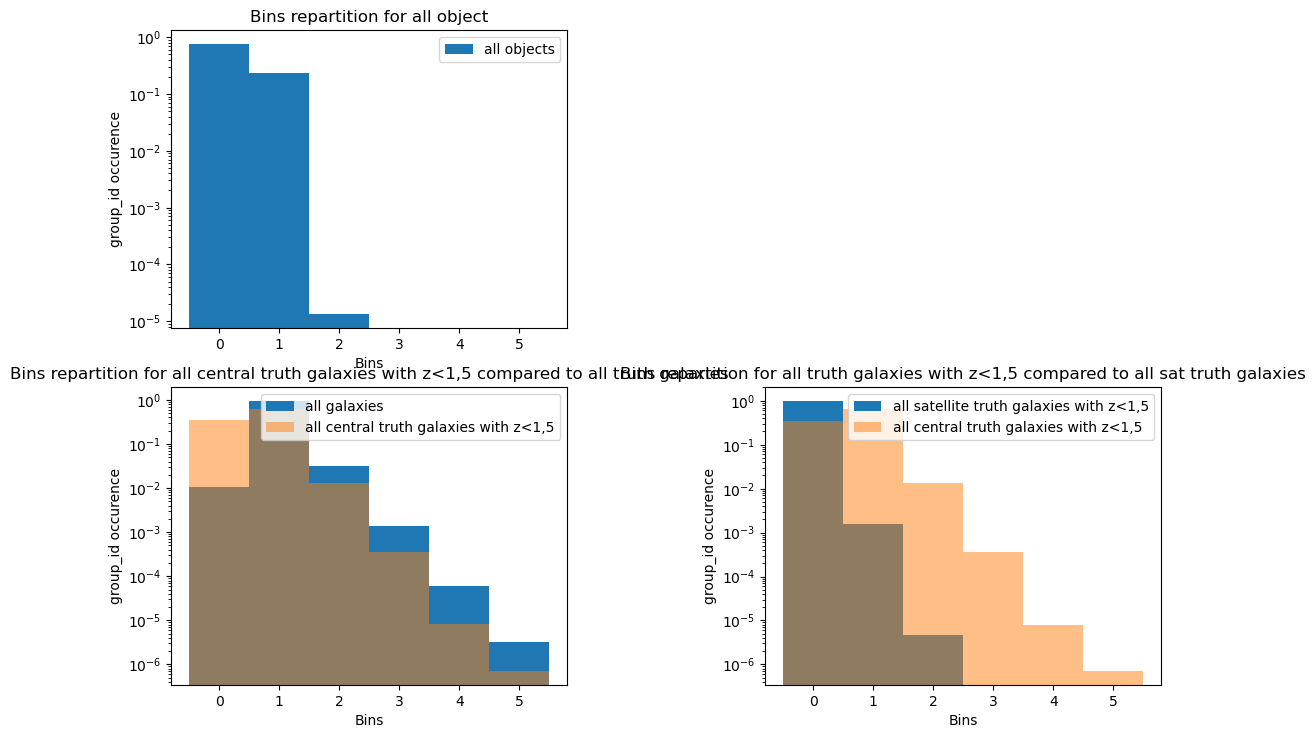

In [97]:
plt.figure(figsize=(11,8.5))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(223)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_z_max_cut_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'all central truth galaxies with z<1,5')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all central truth galaxies with z<1,5 compared to all truth galaxies')

plt2=plt.subplot(221)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

plt3=plt.subplot(224)
n_truth_z_max_cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where(truth_data['redshift'][ind_galax][ind_galax_sat]>z_max_cut)[0]]['group_id'],
                                    minlength=n_groups)
hist1mass=plt.hist(n_truth_halo_mass_cut_sat, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all satellite truth galaxies with z<1,5")
hist2mass=plt.hist(n_truth_z_max_cut_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'all central truth galaxies with z<1,5')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all truth galaxies with z<1,5 compared to all sat truth galaxies')

#plt.savefig('halo_mass_z_cut_plot/Bins repartition for all truth galaxies with z<1,5 compared to all truth galaxies and to all sat truth galaxies')
plt.show()

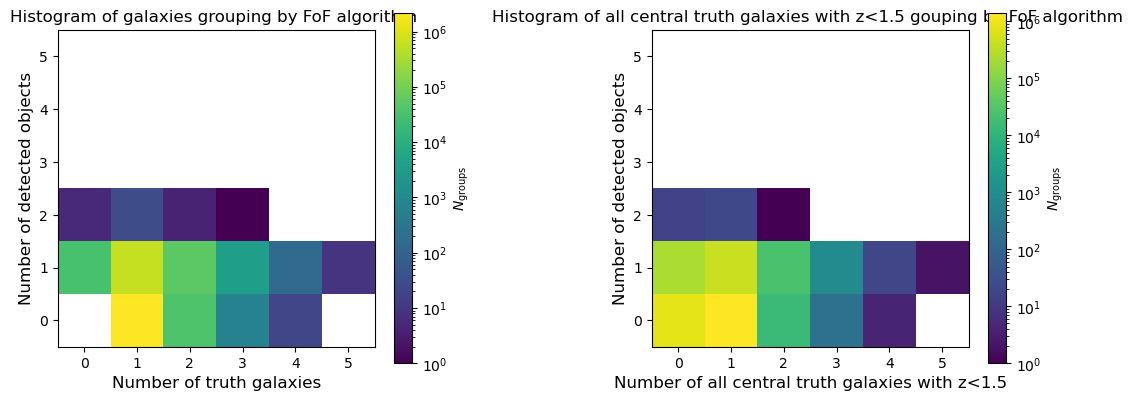

In [98]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_z_max_central=plt.hist2d(n_truth_z_max_cut_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of all central truth galaxies with z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all central truth galaxies with z<1.5 gouping by FoF algorithm ')

#plt.savefig('halo_mass_z_cut_plot/Histogram of all central truth galaxies with z<1.5 gouping by FoF algorithm')
plt.show()

In [99]:
print("missed detections :")

print("nbr of (1-0) systems for all central truth galaxies with z<1,5 =", hist2d2_z_max_central[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_z_max_central[0][1,1])


print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_z_max_central[0][2,1])

missed detections :
nbr of (1-0) systems for all central truth galaxies with z<1,5 = 1386226.0
recognized blending :
nbr of (1-1) systems = 418627.0
unrecognized blending :
nbr of (2-1) systems = 23526.0


In [100]:
print("% of (1-0) systems in all central truth galaxies with z<1,5 :",
     (hist2d2_z_max_central[0][1,0]/len(results[truth_mask][ind_galax_central][np.where(truth_data['redshift'][ind_galax][ind_galax_central]<z_max_cut)[0]]))*100)

print("% of (1-1) systems in all central truth galaxies with z<1,5 :",
     (hist2d2_z_max_central[0][1,1]/len(results[truth_mask][ind_galax_central][np.where(truth_data['redshift'][ind_galax][ind_galax_central]<z_max_cut)[0]]))*100)

print("% of (2-1) systems in all central truth galaxies with z<1,5 :",
     (hist2d2_z_max_central[0][2,1]/len(results[truth_mask][ind_galax_central][np.where(truth_data['redshift'][ind_galax][ind_galax_central]<z_max_cut)[0]]))*100)

% of (1-0) systems in all central truth galaxies with z<1,5 : 73.57664868950356
% of (1-1) systems in all central truth galaxies with z<1,5 : 22.21944452848295
% of (2-1) systems in all central truth galaxies with z<1,5 : 1.24868833586245


## z-max-cut study for satellite galaxies :

In [101]:
len(results[truth_mask][ind_galax_sat][np.where(truth_data['redshift'][ind_galax][ind_galax_sat]<z_max_cut)[0]])

153962

In [102]:
n_truth_z_max_cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where(truth_data['redshift'][ind_galax][ind_galax_sat]>z_max_cut)[0]]['group_id'],
                                    minlength=n_groups)

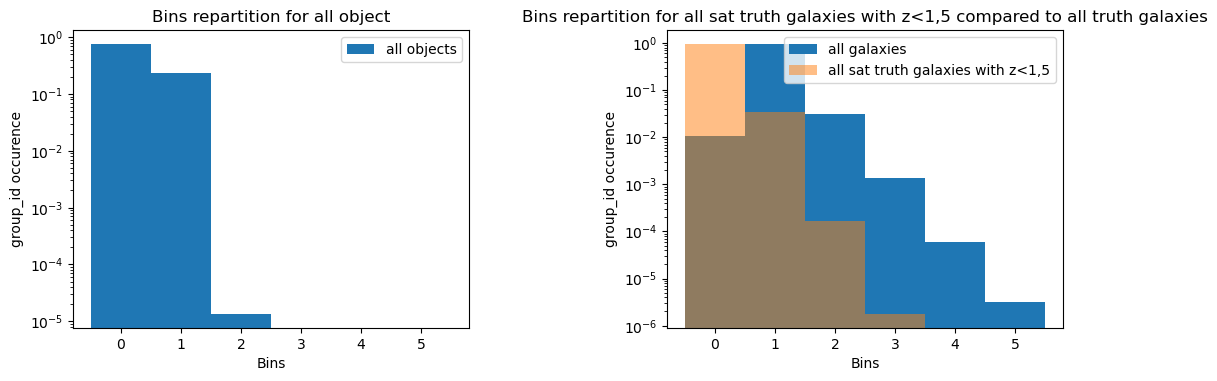

In [103]:
plt.figure(figsize=(11,8.5))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(222)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_z_max_cut_sat, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'all sat truth galaxies with z<1,5')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all sat truth galaxies with z<1,5 compared to all truth galaxies')

plt2=plt.subplot(221)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

plt.show()

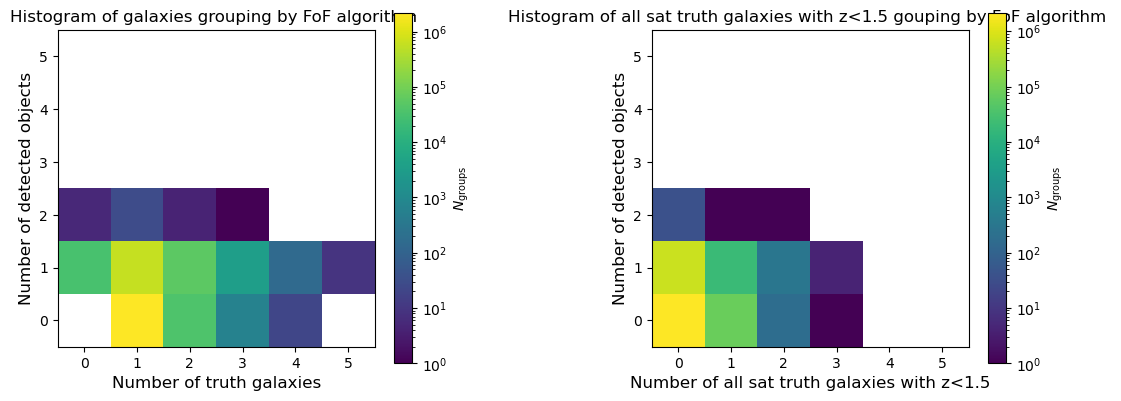

In [104]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_z_max_sat=plt.hist2d(n_truth_z_max_cut_sat, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of all sat truth galaxies with z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all sat truth galaxies with z<1.5 gouping by FoF algorithm ')

plt.show()

In [105]:
print("missed detections :")

print("nbr of (1-0) systems for all central truth galaxies with z>1,5 =", hist2d2_z_max_sat[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_z_max_sat[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_z_max_sat[0][2,1])

missed detections :
nbr of (1-0) systems for all central truth galaxies with z>1,5 = 76916.0
recognized blending :
nbr of (1-1) systems = 19665.0
unrecognized blending :
nbr of (2-1) systems = 311.0


In [106]:
print("% of (1-0) systems in all sat truth galaxies with z<1,5 :",
     (hist2d2_z_max_sat[0][1,0]/len(results[truth_mask][ind_galax_sat][np.where(truth_data['redshift'][ind_galax][ind_galax_sat]<z_max_cut)[0]]))*100)

print("% of (1-1) systems in all sat truth galaxies with z<1,5 :",
     (hist2d2_z_max_sat[0][1,1]/len(results[truth_mask][ind_galax_sat][np.where(truth_data['redshift'][ind_galax][ind_galax_sat]<z_max_cut)[0]]))*100)

print("% of (2-1) systems in all sat truth galaxies with z<1,5 :",
     (hist2d2_z_max_sat[0][2,1]/len(results[truth_mask][ind_galax_sat][np.where(truth_data['redshift'][ind_galax][ind_galax_sat]<z_max_cut)[0]]))*100)

% of (1-0) systems in all sat truth galaxies with z<1,5 : 49.9577817903119
% of (1-1) systems in all sat truth galaxies with z<1,5 : 12.772632207947415
% of (2-1) systems in all sat truth galaxies with z<1,5 : 0.20199789558462475


# Mass + z max cut :

In [107]:
truth_data_halo_mass= truth_data['halo_mass'][ind_galax]

truth_data_z= truth_data['redshift'][ind_galax]

In [108]:
halo_mass_cut_13=1e13

z_max_cut= 1.5

## Mass >1e13 + z-max-cut study for all galaxies :

In [109]:
results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]

row_index,catalog_key,group_id
int64,str6,int64
449081,galaxy,155
1877494,galaxy,535
1877504,galaxy,557
2046346,galaxy,695
2046360,galaxy,721
2046384,galaxy,721
1989110,galaxy,767
2048330,galaxy,794
1998319,galaxy,1459


In [110]:
n_truth_2cut_all = np.bincount(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]['group_id'],
                               minlength=n_groups)

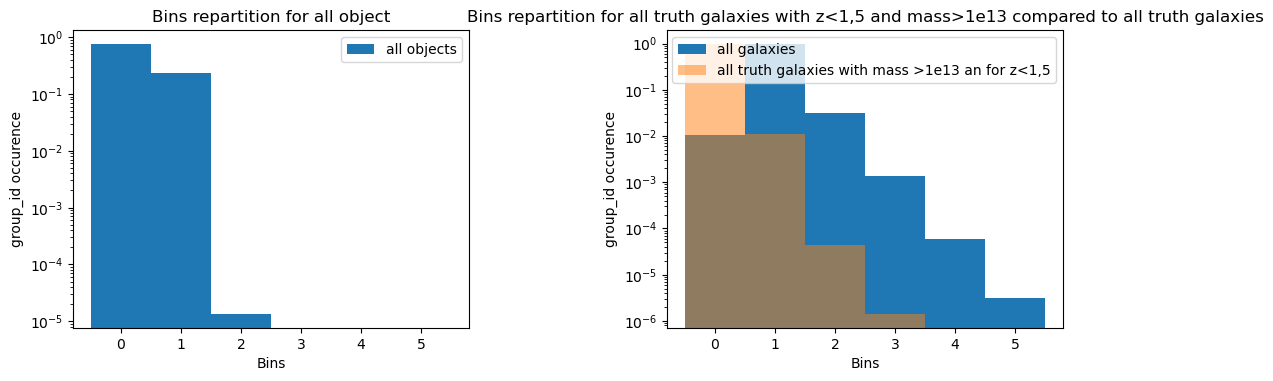

In [111]:
plt.figure(figsize=(11,8.5))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(222)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_2cut_all, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'all truth galaxies with mass >1e13 an for z<1,5')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all truth galaxies with z<1,5 and mass>1e13 compared to all truth galaxies')

plt2=plt.subplot(221)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

plt.show()

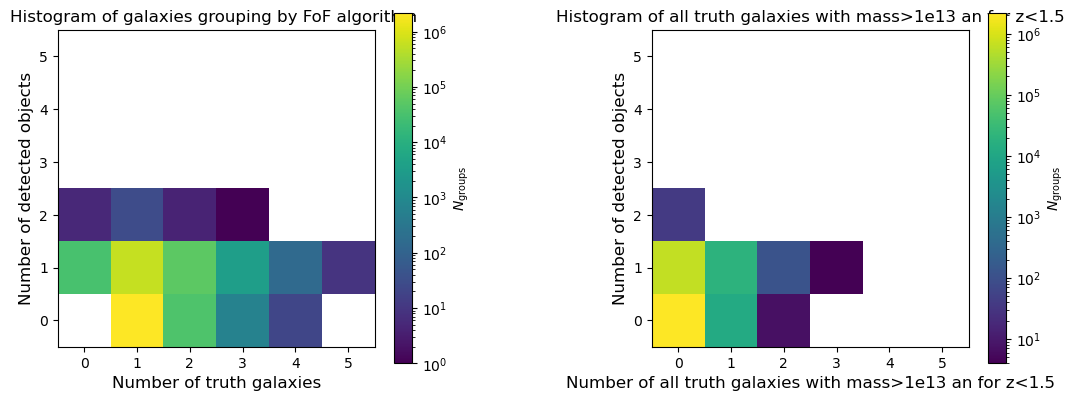

In [112]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_all=plt.hist2d(n_truth_2cut_all, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of all truth galaxies with mass>1e13 an for z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all truth galaxies with mass>1e13 an for z<1.5')

plt.show()

In [113]:
print("missed detections :")

print("nbr of (1-0) systems for all truth galaxies with z>1,5 =", hist2d2_2cut_all[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_all[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_all[0][2,1])

missed detections :
nbr of (1-0) systems for all truth galaxies with z>1,5 = 12003.0
recognized blending :
nbr of (1-1) systems = 19615.0
unrecognized blending :
nbr of (2-1) systems = 116.0


In [114]:
print("% of (1-0) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][1,0]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]))*100)

print("% of (1-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][1,1]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]))*100)

print("% of (2-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][2,1]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]))*100)

% of (1-0) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 37.65528924582758
% of (1-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 61.535324381980175
% of (2-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 0.3639101518383737


## Mass >1e13 + z-max-cut study for central galaxies :

In [115]:
results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]

row_index,catalog_key,group_id
int64,str6,int64
1771174,galaxy,2290
1765588,galaxy,3802
1877492,galaxy,4368
995728,galaxy,4786
992345,galaxy,5419
1989092,galaxy,5806
2046342,galaxy,5856
2048329,galaxy,6330
1885534,galaxy,6723


In [116]:
n_truth_2cut_central = np.bincount(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]['group_id'],
                               minlength=n_groups)

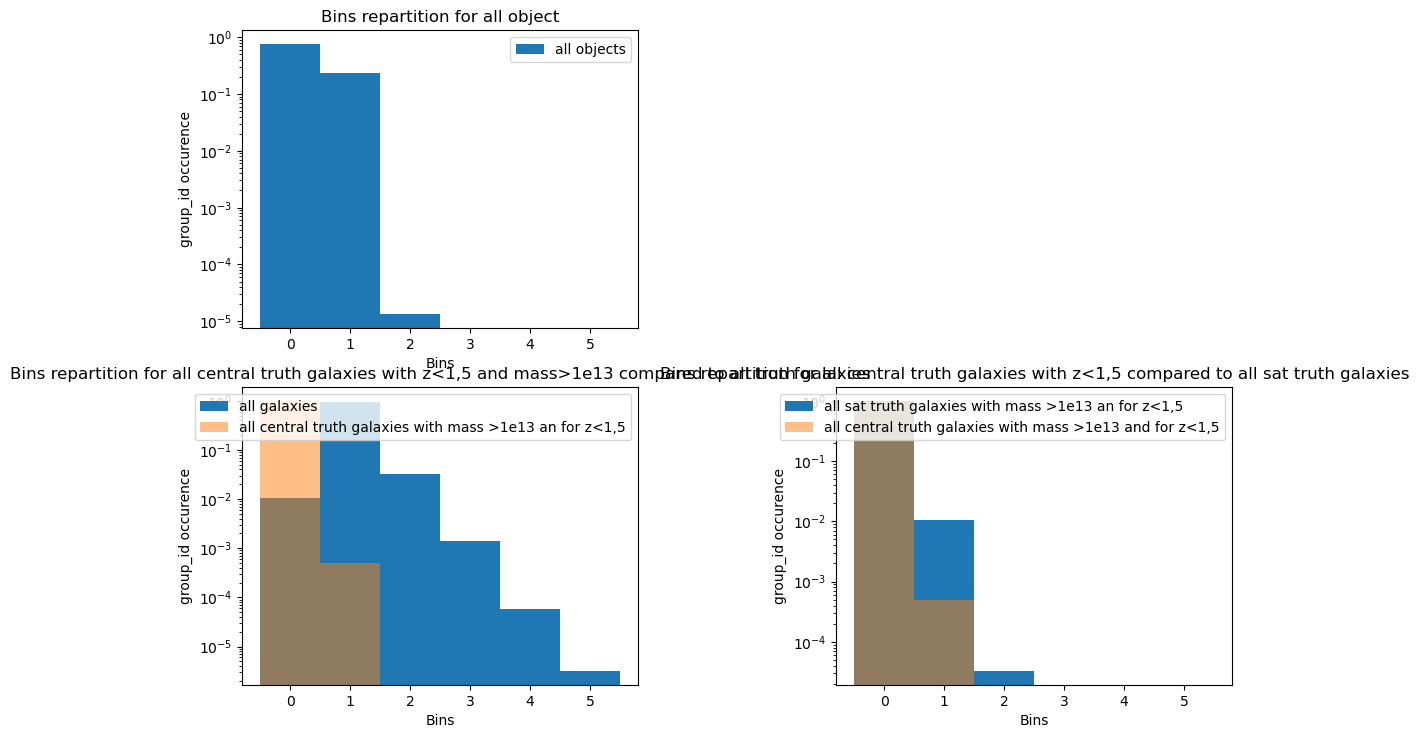

In [117]:
plt.figure(figsize=(11,8.5))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(223)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_2cut_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'all central truth galaxies with mass >1e13 an for z<1,5')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all central truth galaxies with z<1,5 and mass>1e13 compared to all truth galaxies')

plt2=plt.subplot(221)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

plt3=plt.subplot(224)
n_truth_2cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]]['group_id'],
                               minlength=n_groups)
hist1mass=plt.hist(n_truth_2cut_sat, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True,
                   label="all sat truth galaxies with mass >1e13 an for z<1,5")
hist2mass=plt.hist(n_truth_2cut_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'all central truth galaxies with mass >1e13 and for z<1,5')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all central truth galaxies with z<1,5 compared to all sat truth galaxies')

plt.show()

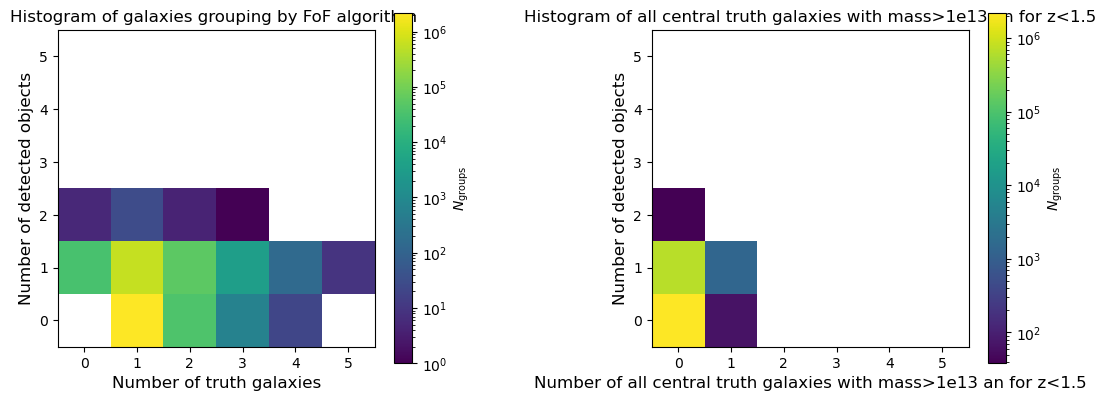

In [118]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_central=plt.hist2d(n_truth_2cut_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of all central truth galaxies with mass>1e13 an for z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all central truth galaxies with mass>1e13 an for z<1.5')

plt.show()

In [119]:
print("missed detections :")

print("nbr of (1-0) systems for all central truth galaxies with z<1,5 and halo_mass>1e13 =", hist2d2_2cut_central[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_central[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_central[0][2,1])

missed detections :
nbr of (1-0) systems for all central truth galaxies with z<1,5 and halo_mass>1e13 = 65.0
recognized blending :
nbr of (1-1) systems = 1349.0
unrecognized blending :
nbr of (2-1) systems = 0.0


In [120]:
print("% of (1-0) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][1,0]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]))*100)

print("% of (1-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][1,1]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]))*100)

print("% of (2-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][2,1]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]))*100)

% of (1-0) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 4.596888260254596
% of (1-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 95.40311173974541
% of (2-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 0.0


## Mass >1e13 + z-max-cut study for sat galaxies :

In [121]:
results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]]

row_index,catalog_key,group_id
int64,str6,int64
449081,galaxy,155
1877494,galaxy,535
1877504,galaxy,557
2046346,galaxy,695
2046360,galaxy,721
2046384,galaxy,721
1989110,galaxy,767
2048330,galaxy,794
1998319,galaxy,1459


In [122]:
n_truth_2cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]]['group_id'],
                               minlength=n_groups)

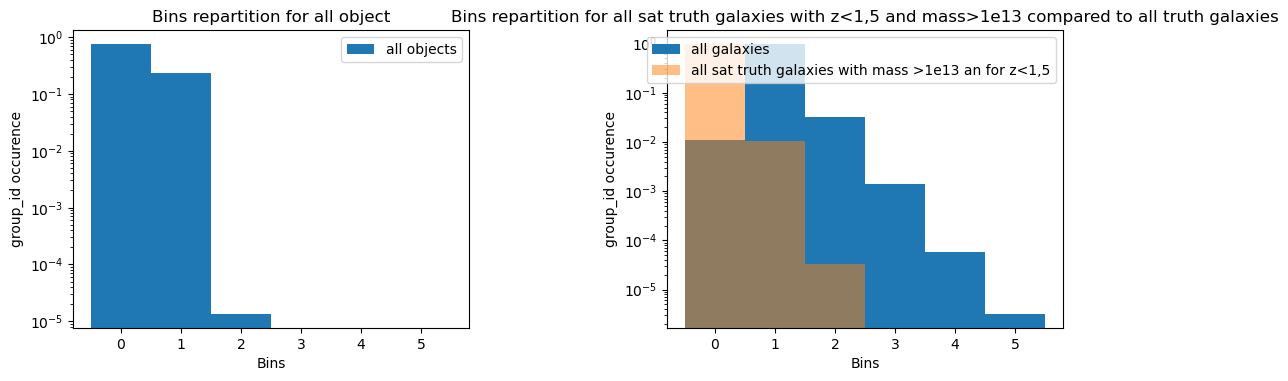

In [123]:
plt.figure(figsize=(11,8.5))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(222)
hist1mass=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all galaxies")
hist2mass=plt.hist(n_truth_2cut_sat, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, alpha = 0.5, density=True,
                label=f'all sat truth galaxies with mass >1e13 an for z<1,5')
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all sat truth galaxies with z<1,5 and mass>1e13 compared to all truth galaxies')

plt2=plt.subplot(221)
hist3=plt.hist(n_object,  bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, density=True, label="all objects")
plt.xlabel('Bins')
plt.ylabel('group_id occurence')
plt.yscale('log')
plt.legend()
plt.title('Bins repartition for all object')

plt.show()

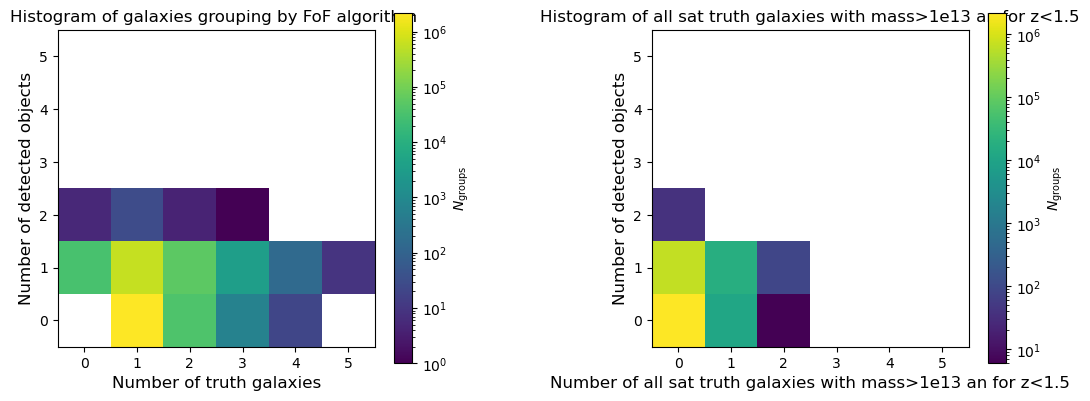

In [124]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_sat=plt.hist2d(n_truth_2cut_sat, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of all sat truth galaxies with mass>1e13 an for z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all sat truth galaxies with mass>1e13 an for z<1.5')

plt.show()

In [125]:
print("missed detections :")

print("nbr of (1-0) systems for all sat truth galaxies with z<1,5 and halo_mass>1e13 =", hist2d2_2cut_sat[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_sat[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_sat[0][2,1])

missed detections :
nbr of (1-0) systems for all sat truth galaxies with z<1,5 and halo_mass>1e13 = 11940.0
recognized blending :
nbr of (1-1) systems = 18336.0
unrecognized blending :
nbr of (2-1) systems = 87.0


In [126]:
print("% of (1-0) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][1,0]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]]))*100)

print("% of (1-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][1,1]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]]))*100)

print("% of (2-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][2,1]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]]))*100)

% of (1-0) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 39.19637581248769
% of (1-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 60.19302737837305
% of (2-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 0.2856017333070711
